# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan z~tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rocie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*.
Trzecim argumentem jest odchyleniem standardowym. Wartość jest dob
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj probowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

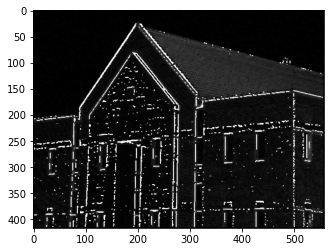

In [5]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate

Img = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)
plt.gray()

dst = cv2.GaussianBlur(Img,(3,3),3)
dst = cv2.Laplacian(dst, cv2.CV_32F)

def threshold_binarization(img, threshold):
    bin_image = img > threshold
    return bin_image.astype(np.int)

def crossing(LoG, thr):
    tab = np.zeros(LoG.shape)
    X, Y = LoG.shape

    size = 3
    ss = size//2

    for i in range(1, X - 1):
        for j in range(1, Y - 1):
           
            env = LoG[i - ss : i + ss +1, j - ss : j + ss+1]

            maxEnv = env.max()
            minEnv = env.min()

            if (maxEnv > 0 and minEnv < 0) or (maxEnv < 0 and minEnv > 0):
                if LoG[i,j] > 0:
                    tab[i,j] = LoG[i,j] + abs(minEnv)

                elif LoG[i,j] <= 0:
                    tab[i,j] = LoG[i,j] + abs(maxEnv)

            else:
                tab[i,j] = LoG[i,j]
                
    tab_nor = cv2.normalize(tab, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    tab_bin = threshold_binarization(tab_nor, thr)
    tab_bin_nor = cv2.normalize(tab_bin, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    tab_bin_nor = tab.astype(np.uint8)
    tab_bin_nor_blur = cv2.medianBlur(tab_bin_nor, size)

    return tab_bin_nor_blur

plt.imshow(crossing(dst,120))


## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w~1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj algorytm detekcji krawędziCanny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Dlatego wykorzystuje się obraz $g_{NL}$ w następującej procedurze:
    - Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
    - Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
    - Stwórz obraz, któy zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
    - Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź.
        Można to wykoanać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH} oraz obraz wynikowy.

    - zlokalizuj następny "nieodwiedzony" piksel krawędziowy $p$ na obrazie $g_{NH}$,
    - oznacz jako poprawne piksele wszystkie "potencjalne" połączone z $p$ (w oknie $3 \times 3$),
    - kontynuuj dla wszystkich piksli z $g_{NH}$,
    - zamień na 0 wszystkie piksele z $g_{NL}$, które nie zostały oznaczone jako poprawne.

Ostateczny rezultat detekcji krawędzi powstaje jako suma $g_{NH}$ i $g_{NL}$ (poprawnych).

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować wbardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj algorytm Cannego.

In [4]:
def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum()

In [6]:
def canny(img):
    X, Y = img.shape
    size = 3
    filter = fgaussian(size=3, sigma=1)
    img = cv2.filter2D(img, -1, filter)
    
    S1 = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]])/9

    S2 = np.array([[-1,-2,-1],
               [ 0, 0, 0],
               [ 1, 2, 1]])/9
    gX = cv2.filter2D(img, -1, S1)**2 #pionowe
    gY = cv2.filter2D(img, -1, S2)**2 #poziome
    
    mXY= (gX + gY)**(0.5)
    aXYradian= np.arctan2(gY, gX)
    aXY = aXYradian * 180. / np.pi
    aXY[aXY < 0] += 180
       
    gN = np.zeros((X,Y))

    TL = 8
    TH = 15
    
    for i in range(1, X - 1):
        for j in range(1, Y - 1):
                q = 255
                r = 255
                if (0 <= aXY[i,j] < 22.5) or (157.5 <= aXY[i,j] <= 180):
                    q = mXY[i, j+1]
                    r = mXY[i, j-1]
                elif (22.5 <= aXY[i,j] < 67.5):
                    q = mXY[i+1, j-1]
                    r = mXY[i-1, j+1]
                elif (67.5 <= aXY[i,j] < 112.5):
                    q = mXY[i+1, j]
                    r = mXY[i-1, j]
                elif (112.5 <= aXY[i,j] < 157.5):
                    q = mXY[i-1, j-1]
                    r = mXY[i+1, j+1]
                      
                if (mXY[i,j] >= q) and (mXY[i,j] >= r):
                    gN[i,j] = mXY[i,j]
                else:
                    gN[i,j] = 0
  
    
    gNH = gN >= TH
    gNL = (gN < TH) & (gN >= TL)
    
    stack = []
    imgVisited = np.zeros((X,Y))
    imgResult = np.zeros((X,Y))
    correctMatrix = np.zeros((X,Y))

    for i in range(0, X):
        for j in range(0, Y):
            if gNH[i,j] == True:
                stack.append([i,j])
    
    while len(stack) > 0:
        XY = stack.pop()
        
        if(imgVisited[XY[0], XY[1]] == False):
            imgVisited[XY[0], XY[1]] = True
            imgResult[XY[0], XY[1]] = 255

            env = gNL[XY[0] - 1 : XY[0] + 2, XY[1] - 1 : XY[1] + 2]
            xEnv, yEnv = env.shape

            for iEnv in range(xEnv):
                for jEnv in range(yEnv):
                    if env[iEnv, jEnv] == True:
                        stack.append([XY[0] - 1 + iEnv, XY[1] - 1 + jEnv])
                        
    for i in range(1, X-1):
        for j in range(1, Y-1):
            if imgVisited[i,j] == False:
                for x in range(i-1,i+1):
                    for y in range(j-1,j+1):
                        if gNL[x,y] == True:
                            correctMatrix[x,y] = True
    
    for i in range(X):
        for j in range(Y):
            if correctMatrix[i,j]==False:
                gNL[i,j] = 0
                

    resultIMG = imgResult + gNL    
    return [gNH, imgResult, resultIMG]     

   

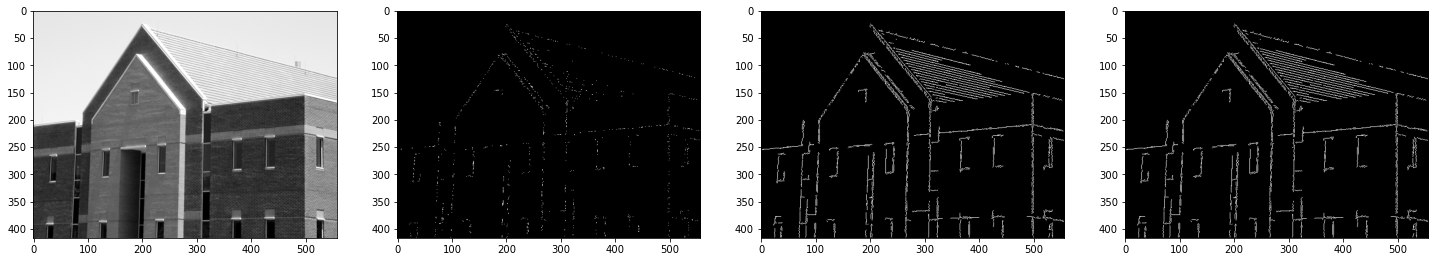

In [7]:
gNH, result, resultIMG = canny(Img)
    
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(25,25))
ax1.imshow(Img)
ax2.imshow(gNH)
ax3.imshow(result)
ax4.imshow(resultIMG)


## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.

In [10]:
newImg = cv2.Canny(Img,100,200,None,3,1)
gNH, result, resultIMG = canny(Img)
    

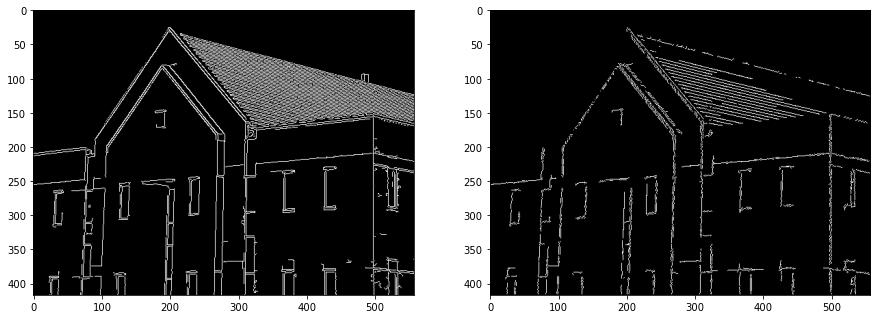

In [11]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,15))

ax1.imshow(newImg)
ax2.imshow(resultIMG)
